### Part 3.2 - Model 1: Multi-Input Keras neural model (latest changes on 25.03.2020)

#### Import standard libraries

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from tabulate import tabulate
import re
import os

import random

# Module to serialize the content produced from the execution of the code

import pickle

# Module to monitor the progress of a python for loop

from tqdm import tqdm_notebook

# Module to manipulate text in python - NLTK package

import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Module to compute word vectorizers and compute the cosine distance

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

import string
import itertools

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:70% !important; }</style>"))

#### Keras Text Classification (For creating the word embeddings)

In [2]:
from nltk.stem import WordNetLemmatizer

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from time import time

#--------------------------------------------------------------

import tensorflow as tf
from tensorflow import keras

import keras.backend as K

from tensorflow.keras import layers
from tensorflow.keras import models

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_addons as tfa

#---------------------------------------------------------------

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from pylab import rcParams

import pydot
import pydotplus
import graphviz

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import json

# Import ML FLow
import mlflow.tensorflow
import mlflow.pyfunc
from tensorflow.keras import regularizers
import datetime

# Import TensorBoard
import tensorflow_docs as tfdocs
import tensorflow_docs.plots as tfplots
import tensorflow_docs.modeling as tfmodel
from tensorflow.keras import regularizers
# from tensorboard import default
# from tensorboard import program

import tensorflow_hub as hub
import bert
from bert import tokenization
from bert.tokenization import FullTokenizer

#Visualize Model

def visualize_model(model):
    return SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import hamming_loss, zero_one_loss, f1_score, roc_auc_score

from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Using TensorFlow backend.


TensorFlow version:  2.1.0
Version:  2.1.0
Eager mode:  True
Hub version:  0.7.0
GPU is NOT AVAILABLE


#### Import the data already tokenized and transformed from Part 3.1

* 80-20 split - Non-balanced data

In [3]:
X_train_seq_actors=np.load(os.path.join(os.getcwd(), "80-20 split_non-balanced\\20000_max_features\\x_train_seq_actors_80-20_non-balanced_20000_25032020.npy"))
X_train_seq_plot=np.load(os.path.join(os.getcwd(), "80-20 split_non-balanced\\20000_max_features\\x_train_seq_plot_80-20_non-balanced_20000_25032020.npy"))
X_train_seq_features=np.load(os.path.join(os.getcwd(), "80-20 split_non-balanced\\20000_max_features\\x_train_seq_features_80-20_non-balanced_20000_25032020.npy"))
X_train_seq_reviews=np.load(os.path.join(os.getcwd(), "80-20 split_non-balanced\\20000_max_features\\x_train_seq_reviews_80-20_non-balanced_20000_25032020.npy"))

print("X_train data inputs have been loaded!\n")

X_test_seq_actors=np.load(os.path.join(os.getcwd(), "80-20 split_non-balanced\\20000_max_features\\x_test_seq_actors_80-20_non-balanced_20000_25032020.npy"))
X_test_seq_plot=np.load(os.path.join(os.getcwd(), "80-20 split_non-balanced\\20000_max_features\\x_test_seq_plot_80-20_non-balanced_20000_25032020.npy"))
X_test_seq_features=np.load(os.path.join(os.getcwd(), "80-20 split_non-balanced\\20000_max_features\\x_test_seq_features_80-20_non-balanced_20000_25032020.npy"))
X_test_seq_reviews=np.load(os.path.join(os.getcwd(), "80-20 split_non-balanced\\20000_max_features\\x_test_seq_reviews_80-20_non-balanced_20000_25032020.npy"))

print("X_test data inputs have been loaded!\n")

y_train=np.load(os.path.join(os.getcwd(), "80-20 split_non-balanced\\20000_max_features\\y_train_80-20_non-balanced_20000_25032020.npy"))
y_test=np.load(os.path.join(os.getcwd(), "80-20 split_non-balanced\\20000_max_features\\y_test_80-20_non-balanced_20000_25032020.npy"))

print("y_train & y_test have been loaded!\n")

X_train data inputs have been loaded!

X_test data inputs have been loaded!

y_train & y_test have been loaded!



In [4]:
X_train_seq_actors.shape

(39193, 17)

#### Import the saved tokenizers

In [5]:
"""
IMport the tokenizers of each input, fitted on part 3.1
"""
with open(os.path.join(os.getcwd(), '80-20 split_non-balanced\\20000_max_features\\actors_tokenizer_20000_25032020.pkl'),'rb') as f:
    actors_tokenizer = pickle.load(f)
    
with open(os.path.join(os.getcwd(), '80-20 split_non-balanced\\20000_max_features\\plot_tokenizer_20000_25032020.pkl'),'rb') as f:
    plot_tokenizer = pickle.load(f)
    
with open(os.path.join(os.getcwd(), '80-20 split_non-balanced\\20000_max_features\\features_tokenizer_20000_25032020.pkl'),'rb') as f:
    features_tokenizer = pickle.load(f)
    
with open(os.path.join(os.getcwd(), '80-20 split_non-balanced\\20000_max_features\\reviews_tokenizer_20000_25032020.pkl'),'rb') as f:
    reviews_tokenizer = pickle.load(f)
    
print("Tokenizers are loaded successfully!")

Tokenizers are loaded successfully!


In [ ]:
# """
# KFold cross validation

# Maybe I could run a Kfold for with k=1 to reshuffle the data.
# """
# X_seq_actors=np.load("C:\\Users\\spano\\Desktop\\GitHub-Thesis\\models_text_classification\\80-20 split_non-balanced\\x_seq_actors_80-20_non-balanced_28022020.npy")
# X_seq_plot=np.load("C:\\Users\\spano\\Desktop\\GitHub-Thesis\\models_text_classification\\80-20 split_non-balanced\\x_seq_plot_80-20_non-balanced_28022020.npy")
# X_seq_features=np.load("C:\\Users\\spano\\Desktop\\GitHub-Thesis\\models_text_classification\\80-20 split_non-balanced\\x_seq_features_80-20_non-balanced_28022020.npy")
# X_seq_reviews=np.load("C:\\Users\\spano\\Desktop\\GitHub-Thesis\\models_text_classification\\80-20 split_non-balanced\\x_seq_reviews_80-20_non-balanced_28022020.npy")

# print("X featurs data inputs have been loaded!\n")

# y=np.load("C:\\Users\\spano\\Desktop\\GitHub-Thesis\\models_text_classification\\80-20 split_non-balanced\\y_80-20_non-balanced_28022020.npy")

# print("y variable has been loaded!\n")

# print("X_seq_actors shape:{}".format(X_seq_actors.shape))
# print("X_seq_plot shape:{}".format(X_seq_plot.shape))
# print("X_seq_features shape:{}".format(X_seq_features.shape))
# print("X_seq_reviews shape:{}\n".format(X_seq_reviews.shape))

# print("y shape:{}".format(y.shape))

# <b>- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  </b>

#### Defining the functions - <i> 15.01.2020 </i>

In [22]:
%load_ext tensorboard
# %reload_text tensorboard

logdir=".\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Callback function with early stopping to avodid overfit

class Callback_Configurations():
    
    MONITOR_METRIC = 'val_loss'
    MINIMUM_DELTA = 0.01
    PATIENCE = 50
    VERBOSE = 1
    MODE = 'min'
    
def callback(saved_model_name, model, logdir):
    
    weights_fname = os.path.join(os.getcwd(), 'model_one\\{}.h5'.format(saved_model_name))

    try:
        with open(os.path.join(os.getcwd(), 'model_one\\{}.json'.format(saved_model_name)), 'r') as f:
            
            model_json = json.load(f)
        
            model = model_from_json(model_json)
        
            model.load_weights('{}').format(weights_fname)

    except:
        print('\nPre-trained weights not found. Fitting from start')
        pass

    monitor_metric = Callback_Configurations.MONITOR_METRIC
    
    callbacks = [
        tfmodel.EpochDots(),
        
        EarlyStopping(monitor=monitor_metric,
                      min_delta=Callback_Configurations.MINIMUM_DELTA,
                      patience=Callback_Configurations.PATIENCE,
                      verbose=Callback_Configurations.VERBOSE,
                      mode=Callback_Configurations.MODE,
                      restore_best_weights=True),

        ModelCheckpoint(filepath=weights_fname,
                        monitor=monitor_metric,
                        verbose=Callback_Configurations.VERBOSE,
                        save_best_only=True,
                        save_weights_only=True), #True, False
        
        tf.keras.callbacks.TensorBoard(logdir)
    ]
    return callbacks

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function to fit the keras multy input model

def fitting_model(method,
                  model,
                  x_train_seq_actors, 
                  x_train_seq_plot, 
                  x_train_seq_features,
                  x_train_seq_reviews,
                  x_test_seq_actors, 
                  x_test_seq_plot, 
                  x_test_seq_features,
                  x_test_seq_reviews,
                  y_train, 
                  y_test,
                  callbacks,
                  steps_per_epoch,
                  epoch,
                  verbose_fit,
                  batch_size_fit,
                  val_split):
    """
    Instead of using validation_data, I used the validation_split parameter
    """
    s = time()
    
    if method=="validation_split":
        
        fit_model = model.fit([x_train_seq_actors, x_train_seq_plot, x_train_seq_features, x_train_seq_reviews], y_train,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epoch,
                              verbose=verbose_fit,
                              batch_size=batch_size_fit,
                              validation_split=val_split, # 90% for train and 10% for validation or 80-20
                              callbacks=callbacks) #(callbacks)
    
    elif method=="validation_data":
        
        fit_model = model.fit([x_train_seq_actors, x_train_seq_plot, x_train_seq_features, x_train_seq_reviews], y_train,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epoch,
                              verbose=verbose_fit,
                              batch_size=batch_size_fit,
                              validation_data=([x_test_seq_actors, x_test_seq_plot, x_test_seq_features, x_test_seq_reviews], y_test),
                              callbacks=callbacks) #(callbacks)

    duration = time() - s
    print("\nTraining time finished. Duration {} secs".format(str(datetime.timedelta(duration))))
    
    return fit_model

# For Kfold cross validation!
# def fitting_model_kfold(model, 
#                         x_seq_actors_train, 
#                         x_seq_plot_train, 
#                         x_seq_features_train,
#                         x_seq_reviews_train,
#                         x_seq_actors_test, 
#                         x_seq_plot_test, 
#                         x_seq_features_test,
#                         x_seq_reviews_test,
#                         y_train,
#                         y_test,
#                         callbacks,
#                         steps_per_epoch,
#                         epoch,
#                         verbose_fit,
#                         batch_size_fit):
#     s = time()

#     fit_model = model.fit([x_seq_actors_train, x_seq_plot_train, x_seq_features_train, x_seq_reviews_train], y_train,
#                           steps_per_epoch = steps_per_epoch,
#                           epochs=epoch,
#                           verbose=verbose_fit,
#                           batch_size=batch_size_fit,
#                           validation_data=([x_seq_actors_test, x_seq_plot_test, x_seq_features_test, x_seq_reviews_test], y_test),
#                           callbacks=callbacks) #(callbacks)

#     duration = time() - s
#     print("\nTraining time finished. Duration {} secs".format(str(datetime.timedelta(duration))))
    
#     return fit_model

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

def save_model(model, model_name):
    
    model_json = model.to_json()

    with open(os.path.join(os.getcwd(), "model_one\\{}.json".format(model_name)), "w") as json_file:
        json.dump(model_json, json_file)

    model.save_weights(os.path.join(os.getcwd(), "model_one\\{}.h5".format(model_name)))
    
    print("\nModel's weights are saved")
    
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# function to plot the model metrics (deprecated)

def plot_model_metrics(fit_model):

    rcParams['figure.figsize'] = 12, 6

    plt.plot(fit_model.history['accuracy'] , 'g') # acc
    plt.plot(fit_model.history['val_accuracy'] , 'b') # val_acc
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.show()

    rcParams['figure.figsize'] = 12, 6

    plt.plot(fit_model.history['loss'] , 'g')
    plt.plot(fit_model.history['val_loss'] , 'b')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.show()

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# alternative function to plot the model metrics (used)

def plot_keras_history(history): #where history =  model.fit()
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()
    
    fig1 = plt.gcf()
    #plt.savefig('multi-input-keras.png')
    plt.show()
    plt.draw()
    fig1.savefig(os.path.join(os.getcwd(), 'model_one\\multi_input_keras.png'), dpi=100)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Create function that will get as input a dataframe with the metrics (validation, accuracy) and create a plot per epoch
# Proposed modules: seaborn, plotly, matplolib.

#source:https://github.com/tensorflow/addons/issues/305
def hamming_loss(y_true, y_pred, mode='multilabel'):
    if mode not in ['multiclass', 'multilabel']:
        raise TypeError('mode must be: [multiclass, multilabel])')

    if mode == 'multiclass':
        nonzero = tf.cast(tf.math.count_nonzero(y_true * y_pred, axis=-1), tf.float32)
        print(nonzero)
        return 1.0 - nonzero

    else:
        nonzero = tf.cast(tf.math.count_nonzero(y_true - y_pred, axis=-1), 
            tf.float32)
        return nonzero / y_true.shape[-1]


class HammingLoss(tfa.metrics.MeanMetricWrapper):
    def __init__(self, name='hamming_loss', dtype=None, mode='multilabel'):
        super(HammingLoss, self).__init__(
                hamming_loss, name, dtype=dtype, mode=mode)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
# Neural Network Structure

neural_network_parameters = {}
optimizer_parameters = {}
fit_parameters = {}

neural_network_parameters['embedding_dimension'] = 50 #Create a for loop to iterate on different values
neural_network_parameters['pool_size'] = None
neural_network_parameters['padding'] = 'valid'
neural_network_parameters['batch_size'] = 128 #Create a for loop to iterate on different values
neural_network_parameters['l2_regularization'] = 0.01 #Grid-search on that value
neural_network_parameters['dropout_rate'] = 0.0 #Grid-search on that value
neural_network_parameters['dense_activation'] = 'relu'
neural_network_parameters['output_activation'] = 'sigmoid' #softmax, sigmoid
neural_network_parameters['number_target_variables'] = len(y_train[0].tolist())

#It’s important to notice, that we use a sigmoid activation function with a multiclass output-layer. 
#The sigmoid gives us independent propabilities for each class. So DON’T use softmax here!

neural_network_parameters['model_loss'] = 'binary_crossentropy' #sparse_categorical_crossentropy, binary_crossentropy, categorical_crossentropy
neural_network_parameters['model_metric'] = 'accuracy' #sparse_categorical_accuracy, accuracy

#--------------------------------------------------------------------------------------
validation_split_ratio=0.8
fit_parameters["steps_per_epoch"] = int(np.ceil((X_train_seq_features.shape[0]*validation_split_ratio)//neural_network_parameters['batch_size']))
fit_parameters["epoch"] = 100
fit_parameters["verbose_fit"] = 0
fit_parameters["batch_size_fit"] = 128 #Grid-search on that value

#---------------------------------------------------------------------------------------

# Optimizer: ADAM (version_1)

optimizer_parameters['adam_learning_rate'] = 0.001
optimizer_parameters['adam_beta_1'] = 0.9
optimizer_parameters['adam_beta_2'] = 0.999
optimizer_parameters['adam_amsgrad'] = False

def optimizer_adam_v1():
    
    return keras.optimizers.Adam(learning_rate=optimizer_parameters['adam_learning_rate'], 
                                 beta_1=optimizer_parameters['adam_beta_1'], 
                                 beta_2=optimizer_parameters['adam_beta_2'], 
                                 amsgrad=optimizer_parameters['adam_amsgrad'])
#---------------------------------------------------------------------------------------

# Optimizer: ADAM (version_2)

# lr_schedule_learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# lr_schedule_decay_rate = [1, 2, 3, 4]

optimizer_parameters['steps_per_epoch'] = int(np.ceil((X_train_seq_features.shape[0]*validation_split_ratio)//neural_network_parameters['batch_size']))
# Steps per epoch...fine tune
optimizer_parameters['lr_schedule_learning_rate'] = 0.01 #Grid-search on that value
optimizer_parameters['lr_schedule_decay_steps'] = optimizer_parameters['steps_per_epoch']*1000
optimizer_parameters['lr_schedule_decay_rate'] = 1 #Grid-search on that value
optimizer_parameters['staircase'] = False

#STEPS_PER_EPOCH = len(X_train_seq_features)//neural_network_parameters['batch_size'] #(512 = BATCH SIZE)

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    optimizer_parameters['lr_schedule_learning_rate'],
    decay_steps=optimizer_parameters['lr_schedule_decay_steps'],
    decay_rate=optimizer_parameters['lr_schedule_decay_rate'],
    staircase=optimizer_parameters['staircase'])

def optimizer_adam_v2():
    
    return keras.optimizers.Adam(lr_schedule)
#---------------------------------------------------------------------------------------

# Optimizer: SDG (version 1)

optimizer_parameters['SGD_learning_rate'] = 0.01
optimizer_parameters['SGD_decay'] = 1e-6
optimizer_parameters['SGD_momentum'] = 0.9
optimizer_parameters['SGD_nesterov'] = True

def optimizer_SDG_v1():
    
    return keras.optimizers.SGD(lr=optimizer_parameters['SGD_learning_rate'],
                                decay=optimizer_parameters['SGD_decay'],
                                momentum=optimizer_parameters['SGD_momentum'],
                                nesterov=optimizer_parameters['SGD_nesterov'])

#---------------------------------------------------------------------------------------

In [8]:
def keras_multy_classification_model_v6(maxlen_actors, 
                                        maxlen_plot, 
                                        maxlen_features, 
                                        maxlen_reviews,
                                        actors_max_words, 
                                        plot_max_words,
                                        features_max_words,
                                        reviews_max_words,
                                        embedding_layer_output_dim,
                                        dense_layer_batch_size,
                                        optimizer_version = None):
    
    sentenceLength_actors = maxlen_actors
    vocab_size_frequent_words_actors = actors_max_words #20001, 12527, 11066, 16334
    
    sentenceLength_plot = maxlen_plot
    vocab_size_frequent_words_plot = plot_max_words #17501, 13295, 10910, 10084
    
    sentenceLength_features = maxlen_features
    vocab_size_frequent_words_features = features_max_words #20001, 17666, 14965, 14440
    
    sentenceLength_reviews = maxlen_reviews
    vocab_size_frequent_words_reviews = reviews_max_words #40001, 16100, 15405, 15251
    
    model = keras.Sequential(name='MultyInput_Keras_Classification_model')
    
    actors = keras.Input(shape=(sentenceLength_actors,), name='actors_input')
    plot = keras.Input(shape=(sentenceLength_plot,), name='plot_input')
    features = keras.Input(shape=(sentenceLength_features,), name='features_input')
    reviews = keras.Input(shape=(sentenceLength_reviews,), name='reviews_input')
    
    emb1 = layers.Embedding(input_dim = vocab_size_frequent_words_actors + 2,
                            output_dim = embedding_layer_output_dim,
                            embeddings_initializer = 'uniform',
                            mask_zero = True,
                            input_length = sentenceLength_actors,
                            name="actors_embedding_layer")(actors)
    
    encoded_layer1 = layers.GlobalMaxPooling1D(name="globalmaxpooling_actors_layer")(emb1)
    
    emb2 = layers.Embedding(input_dim = vocab_size_frequent_words_plot + 2,
                            output_dim = embedding_layer_output_dim,
                            embeddings_initializer = 'uniform',
                            mask_zero = True,
                            input_length = sentenceLength_plot,
                            name="plot_embedding_layer")(plot)
    
    encoded_layer2 = layers.GlobalMaxPooling1D(name="globalmaxpooling_plot_summary_Layer")(emb2)

    emb3 = layers.Embedding(input_dim = vocab_size_frequent_words_features + 2,
                            output_dim = embedding_layer_output_dim,
                            embeddings_initializer = 'uniform',
                            mask_zero = True,
                            input_length = sentenceLength_features,
                            name="features_embedding_layer")(features)
    
    encoded_layer3 = layers.GlobalMaxPooling1D(name="globalmaxpooling_movie_features_layer")(emb3)
    
    emb4 = layers.Embedding(input_dim = vocab_size_frequent_words_reviews + 2,
                            output_dim = embedding_layer_output_dim,
                            embeddings_initializer = 'uniform',
                            mask_zero = True,
                            input_length = sentenceLength_reviews,
                            name="reviews_embedding_layer")(reviews)
    
    encoded_layer4 = layers.GlobalMaxPooling1D(name="globalmaxpooling_user_reviews_layer")(emb4)
    
    merged = layers.concatenate([encoded_layer1, encoded_layer2, encoded_layer3, encoded_layer4], axis=-1)

    dense_layer_1 = layers.Dense(dense_layer_batch_size,
                                 kernel_regularizer=regularizers.l2(neural_network_parameters['l2_regularization']),
                                 activation=neural_network_parameters['dense_activation'],
                                 name="1st_dense_layer_concatenated_inputs")(merged)
    layers.Dropout(neural_network_parameters['dropout_rate'])(dense_layer_1)
    
    output_layer = layers.Dense(neural_network_parameters['number_target_variables'], activation=neural_network_parameters['output_activation'],
                                name='output_layer')(dense_layer_1)
    
    model = keras.Model(inputs=[actors, plot, features, reviews], outputs=output_layer)
    
    print(model.output_shape)

    print(model.summary())
    
    # Version_2 of Adam
    if optimizer_version is None:
        
        optimizer = optimizer_adam_v2()
    
    model.compile(optimizer=optimizer,
                  loss=neural_network_parameters['model_loss'],
                  metrics=[neural_network_parameters['model_metric']])
    
    plot_model(model, to_file=os.path.join(os.getcwd(), 'model_one\\structure_multy_input_keras_model.png'))
    
    return model

#### Prior to fitting the model: 

* X_train, X_test should have the form of an array with sequence of numbers.
* y_train, y_test should have the form of a multi-hot encoded dataframe.

<b> General observations: </b>

* Reducing batch size can produce a better model (I should grid search on batch size).
* Reducing the general number of parameters can produce better results.
* Removing the second dense layer improved the results.
* Removing regularization also affected the results.

(None, 17)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actors_input (InputLayer)       [(None, 17)]         0                                            
__________________________________________________________________________________________________
plot_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
features_input (InputLayer)     [(None, 57)]         0                                            
__________________________________________________________________________________________________
reviews_input (InputLayer)      [(None, 254)]        0                                            
___________________________________________________________________________________

C:\Users\spano\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\training\tracking\data_structures.py:720: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):



Pre-trained weights not found. Fitting from start

Epoch: 0, accuracy:0.9160,  loss:0.2884,  val_accuracy:0.9410,  val_loss:0.2141,  
.
Epoch 00001: val_loss improved from inf to 0.21410, saving model to C:\Users\spano\Desktop\GitHub- Thesis\models_text_classification\model_one\multi_input_keras_model_50dim_16batchsize.h5
.
Epoch 00002: val_loss improved from 0.21410 to 0.16849, saving model to C:\Users\spano\Desktop\GitHub- Thesis\models_text_classification\model_one\multi_input_keras_model_50dim_16batchsize.h5
.
Epoch 00003: val_loss improved from 0.16849 to 0.13113, saving model to C:\Users\spano\Desktop\GitHub- Thesis\models_text_classification\model_one\multi_input_keras_model_50dim_16batchsize.h5
.
Epoch 00004: val_loss improved from 0.13113 to 0.10706, saving model to C:\Users\spano\Desktop\GitHub- Thesis\models_text_classification\model_one\multi_input_keras_model_50dim_16batchsize.h5
.
Epoch 00005: val_loss improved from 0.10706 to 0.10598, saving model to C:\Users\spano\Desk

+----+-----------+------------+------------+----------------+---------+

Model's weights are saved


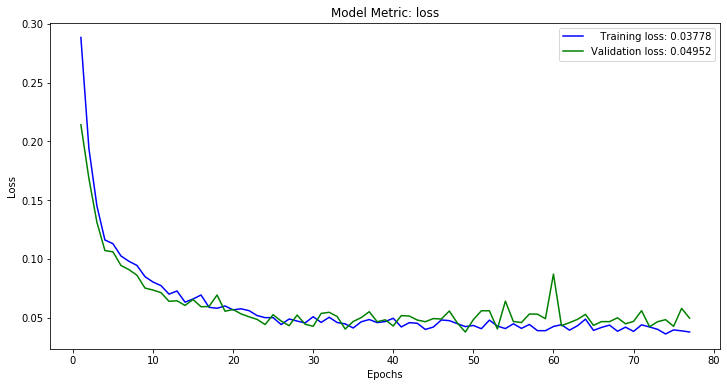

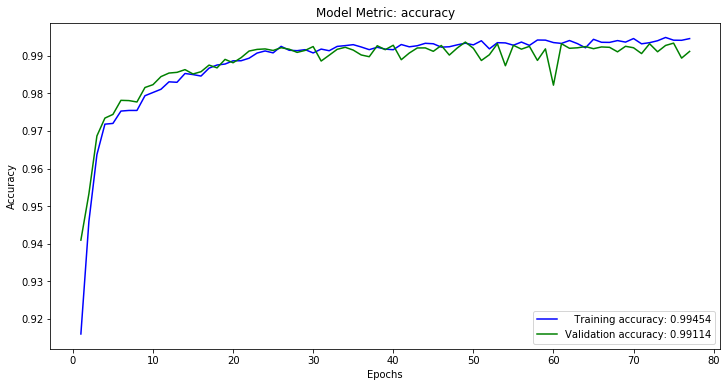

9799/9799 - 1s - loss: 0.0436 - accuracy: 0.9915

Test Score (evalution of the model's loss/error on the test sequences): 0.043602149892898345

Test Accuracy (evalution of the model's accuracy on the test sequences): 0.99153864
(None, 17)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actors_input (InputLayer)       [(None, 17)]         0                                            
__________________________________________________________________________________________________
plot_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
features_input (InputLayer)     [(None, 57)]         0                                            
___________________________________________________

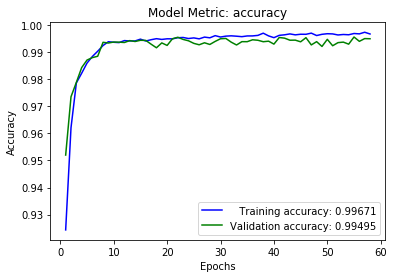

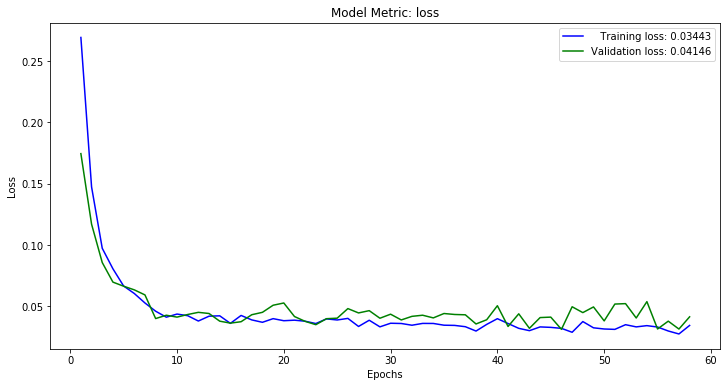

9799/9799 - 0s - loss: 0.0407 - accuracy: 0.9935

Test Score (evalution of the model's loss/error on the test sequences): 0.0407366027228868

Test Accuracy (evalution of the model's accuracy on the test sequences): 0.9935477
(None, 17)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actors_input (InputLayer)       [(None, 17)]         0                                            
__________________________________________________________________________________________________
plot_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
features_input (InputLayer)     [(None, 57)]         0                                            
______________________________________________________

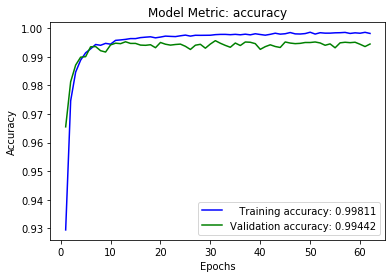

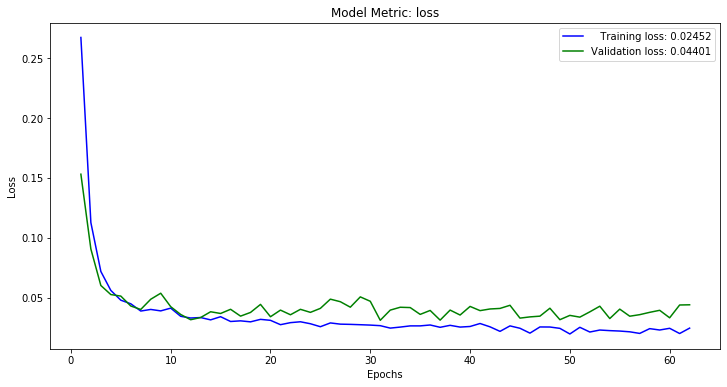

9799/9799 - 0s - loss: 0.0307 - accuracy: 0.9947

Test Score (evalution of the model's loss/error on the test sequences): 0.03069169738530772

Test Accuracy (evalution of the model's accuracy on the test sequences): 0.9947357
(None, 17)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actors_input (InputLayer)       [(None, 17)]         0                                            
__________________________________________________________________________________________________
plot_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
features_input (InputLayer)     [(None, 57)]         0                                            
_____________________________________________________

+----+-----------+------------+------------+----------------+---------+

Model's weights are saved


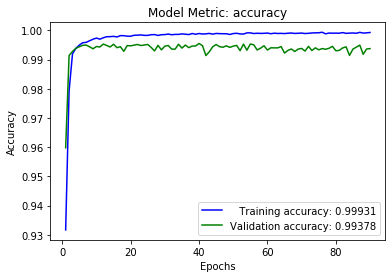

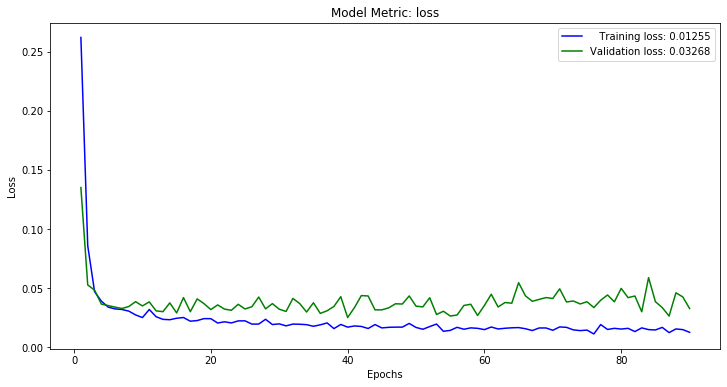

9799/9799 - 0s - loss: 0.0246 - accuracy: 0.9957

Test Score (evalution of the model's loss/error on the test sequences): 0.024604177407913517

Test Accuracy (evalution of the model's accuracy on the test sequences): 0.9956898
(None, 17)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actors_input (InputLayer)       [(None, 17)]         0                                            
__________________________________________________________________________________________________
plot_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
features_input (InputLayer)     [(None, 57)]         0                                            
____________________________________________________

+-----+-----------+------------+------------+----------------+---------+

Model's weights are saved


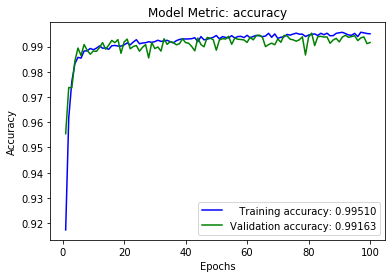

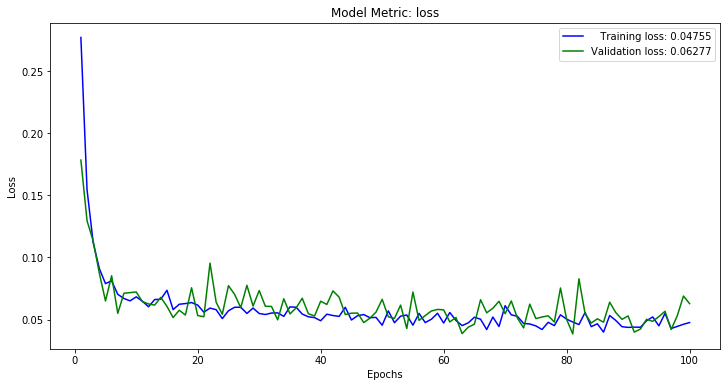

9799/9799 - 1s - loss: 0.0638 - accuracy: 0.9911

Test Score (evalution of the model's loss/error on the test sequences): 0.06382717649213926

Test Accuracy (evalution of the model's accuracy on the test sequences): 0.99111867
(None, 17)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actors_input (InputLayer)       [(None, 17)]         0                                            
__________________________________________________________________________________________________
plot_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
features_input (InputLayer)     [(None, 57)]         0                                            
____________________________________________________

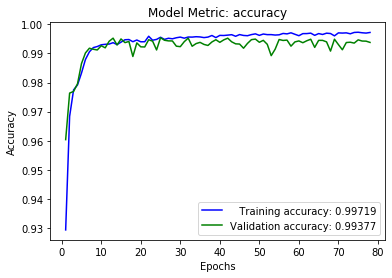

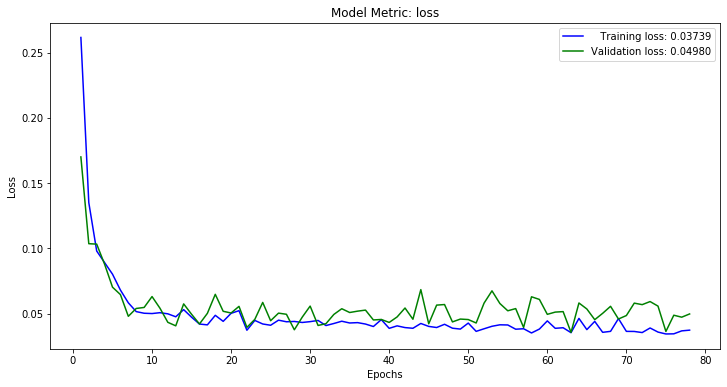

9799/9799 - 1s - loss: 0.0378 - accuracy: 0.9944

Test Score (evalution of the model's loss/error on the test sequences): 0.037757310127102484

Test Accuracy (evalution of the model's accuracy on the test sequences): 0.994376
(None, 17)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actors_input (InputLayer)       [(None, 17)]         0                                            
__________________________________________________________________________________________________
plot_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
features_input (InputLayer)     [(None, 57)]         0                                            
_____________________________________________________

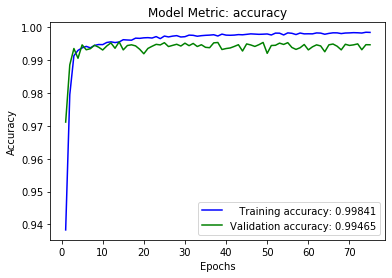

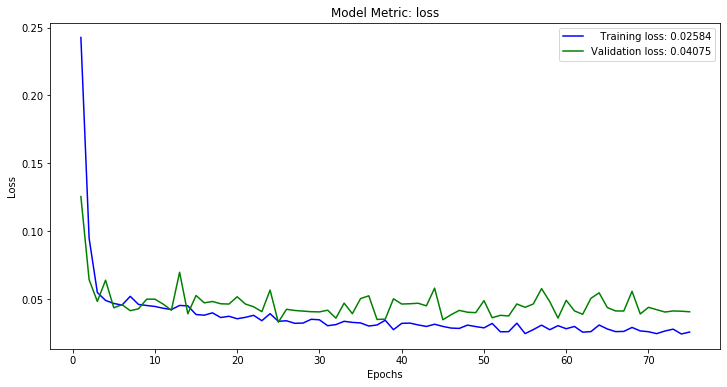

9799/9799 - 0s - loss: 0.0328 - accuracy: 0.9955

Test Score (evalution of the model's loss/error on the test sequences): 0.032798219613213116

Test Accuracy (evalution of the model's accuracy on the test sequences): 0.99551624
(None, 17)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actors_input (InputLayer)       [(None, 17)]         0                                            
__________________________________________________________________________________________________
plot_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
features_input (InputLayer)     [(None, 57)]         0                                            
___________________________________________________

+-----+-----------+------------+------------+----------------+---------+

Model's weights are saved


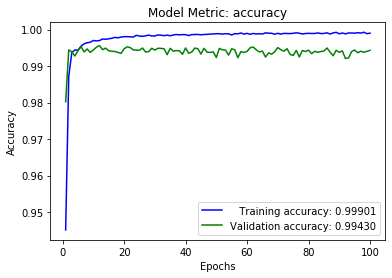

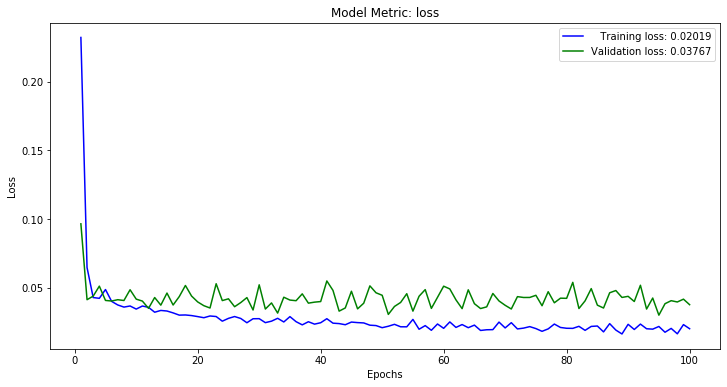

9799/9799 - 0s - loss: 0.0364 - accuracy: 0.9945

Test Score (evalution of the model's loss/error on the test sequences): 0.03641150185538197

Test Accuracy (evalution of the model's accuracy on the test sequences): 0.99445325
(None, 17)
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actors_input (InputLayer)       [(None, 17)]         0                                            
__________________________________________________________________________________________________
plot_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
features_input (InputLayer)     [(None, 57)]         0                                            
____________________________________________________

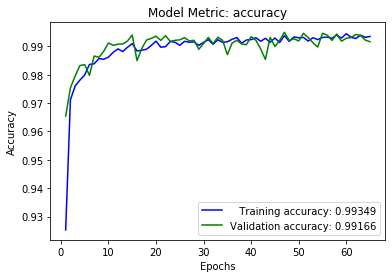

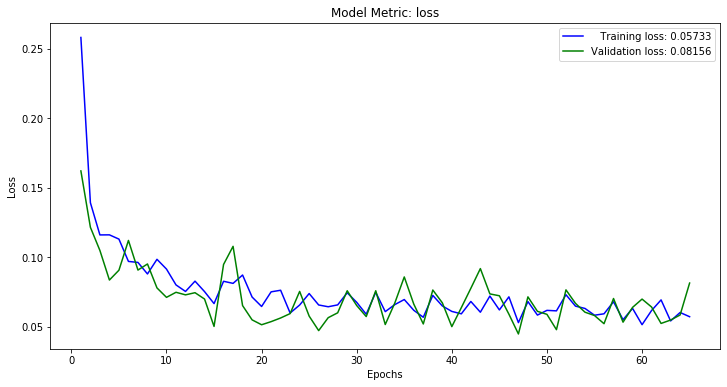

9799/9799 - 1s - loss: 0.0514 - accuracy: 0.9936

Test Score (evalution of the model's loss/error on the test sequences): 0.051376689617390996

Test Accuracy (evalution of the model's accuracy on the test sequences): 0.9936218
(None, 17)
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actors_input (InputLayer)       [(None, 17)]         0                                            
__________________________________________________________________________________________________
plot_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
features_input (InputLayer)     [(None, 57)]         0                                            
____________________________________________________

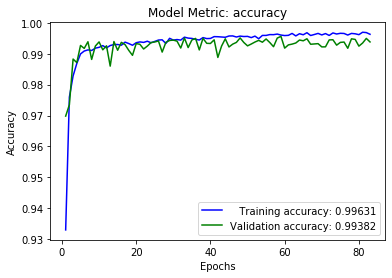

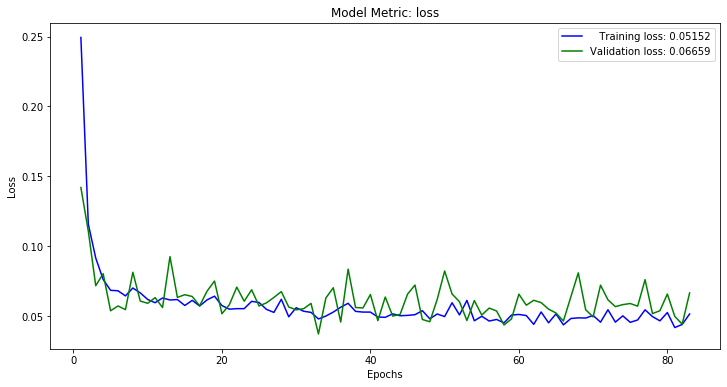

9799/9799 - 1s - loss: 0.0383 - accuracy: 0.9950

Test Score (evalution of the model's loss/error on the test sequences): 0.03829623690666332

Test Accuracy (evalution of the model's accuracy on the test sequences): 0.9949951
(None, 17)
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actors_input (InputLayer)       [(None, 17)]         0                                            
__________________________________________________________________________________________________
plot_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
features_input (InputLayer)     [(None, 57)]         0                                            
____________________________________________________

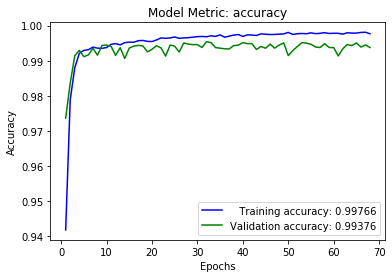

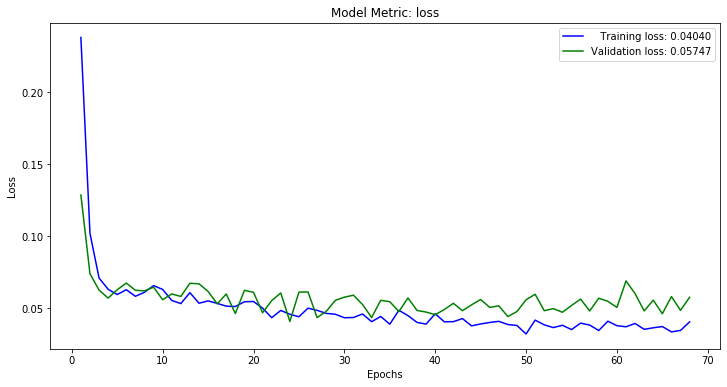

9799/9799 - 1s - loss: 0.0459 - accuracy: 0.9943

Test Score (evalution of the model's loss/error on the test sequences): 0.04591806955861369

Test Accuracy (evalution of the model's accuracy on the test sequences): 0.99427325
(None, 17)
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actors_input (InputLayer)       [(None, 17)]         0                                            
__________________________________________________________________________________________________
plot_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
features_input (InputLayer)     [(None, 57)]         0                                            
___________________________________________________

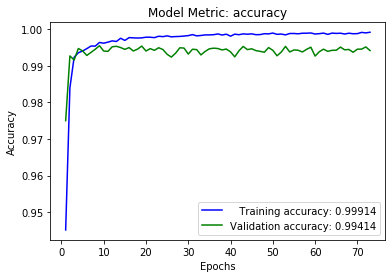

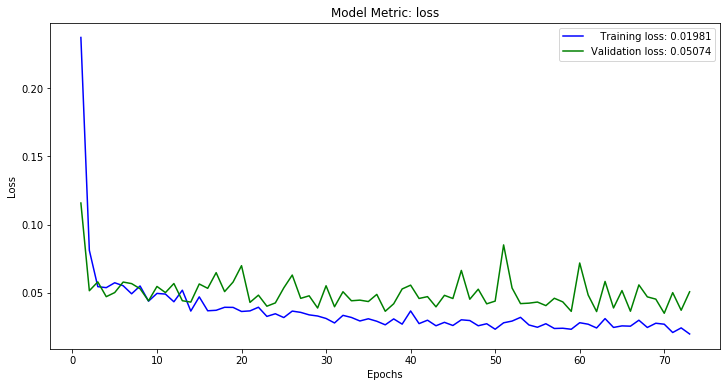

9799/9799 - 1s - loss: 0.0397 - accuracy: 0.9951

Test Score (evalution of the model's loss/error on the test sequences): 0.03966886362269808

Test Accuracy (evalution of the model's accuracy on the test sequences): 0.9950715
(None, 17)
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actors_input (InputLayer)       [(None, 17)]         0                                            
__________________________________________________________________________________________________
plot_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
features_input (InputLayer)     [(None, 57)]         0                                            
____________________________________________________

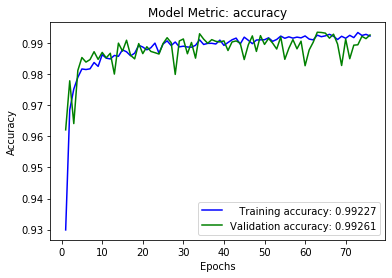

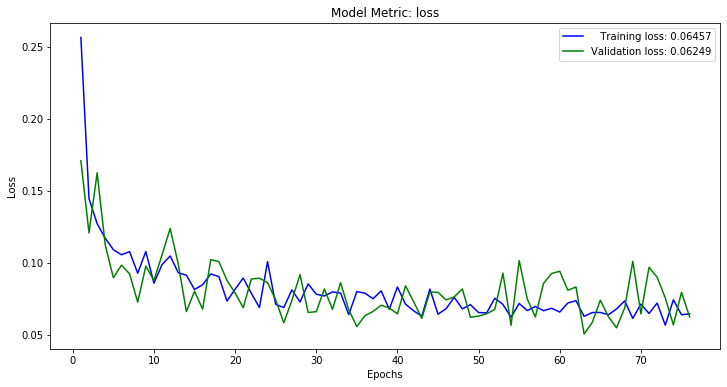

9799/9799 - 1s - loss: 0.0588 - accuracy: 0.9914

Test Score (evalution of the model's loss/error on the test sequences): 0.0587773434958454

Test Accuracy (evalution of the model's accuracy on the test sequences): 0.99141824
(None, 17)
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actors_input (InputLayer)       [(None, 17)]         0                                            
__________________________________________________________________________________________________
plot_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
features_input (InputLayer)     [(None, 57)]         0                                            
____________________________________________________

+-----+-----------+------------+------------+----------------+---------+

Model's weights are saved


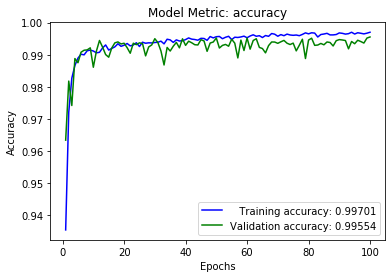

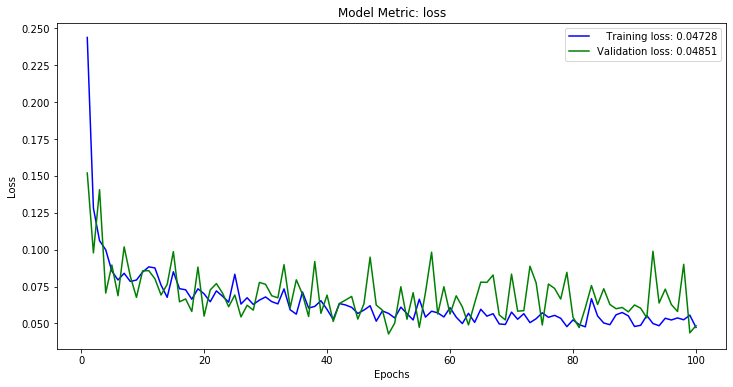

9799/9799 - 1s - loss: 0.0430 - accuracy: 0.9953

Test Score (evalution of the model's loss/error on the test sequences): 0.04297832961954843

Test Accuracy (evalution of the model's accuracy on the test sequences): 0.99527687
(None, 17)
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actors_input (InputLayer)       [(None, 17)]         0                                            
__________________________________________________________________________________________________
plot_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
features_input (InputLayer)     [(None, 57)]         0                                            
___________________________________________________

+----+-----------+------------+------------+----------------+---------+

Model's weights are saved


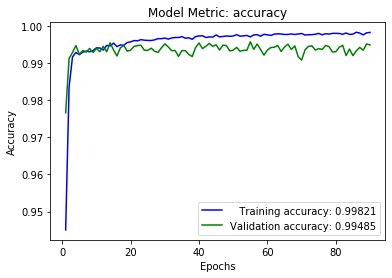

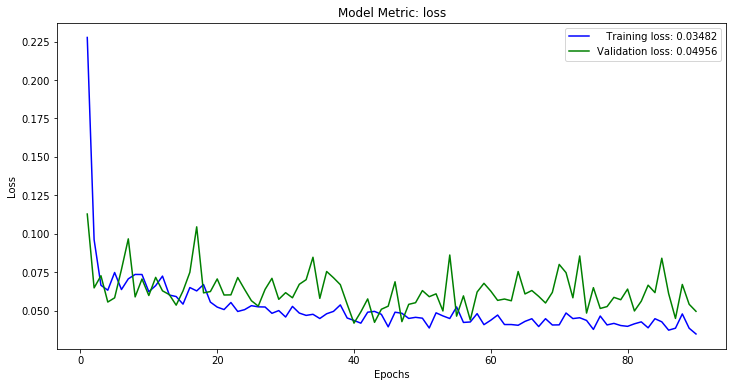

9799/9799 - 1s - loss: 0.0415 - accuracy: 0.9954

Test Score (evalution of the model's loss/error on the test sequences): 0.04149091568561534

Test Accuracy (evalution of the model's accuracy on the test sequences): 0.99538386
(None, 17)
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actors_input (InputLayer)       [(None, 17)]         0                                            
__________________________________________________________________________________________________
plot_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
features_input (InputLayer)     [(None, 57)]         0                                            
___________________________________________________

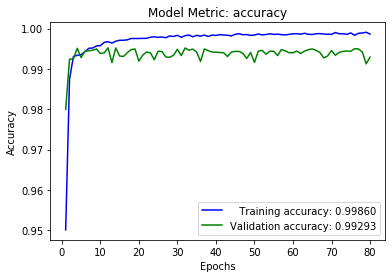

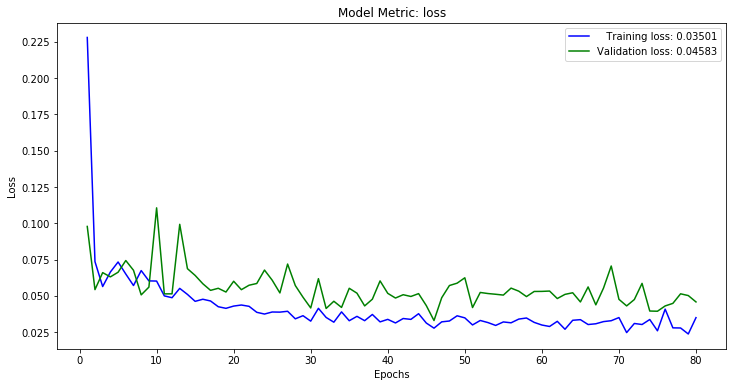

9799/9799 - 1s - loss: 0.0424 - accuracy: 0.9949

Test Score (evalution of the model's loss/error on the test sequences): 0.042408216844646164

Test Accuracy (evalution of the model's accuracy on the test sequences): 0.99486744


<Figure size 432x288 with 0 Axes>

In [9]:
embedding_layer_dimension=[50, 100, 200, 300]
layer_batch_size=[16, 32, 64, 128]

model_repository = {}

model_history = {}

for i in embedding_layer_dimension:
    
    for j in layer_batch_size:
        
        mlflow.set_experiment("/multi_input_keras_model")

        with mlflow.start_run(run_name="multi_input_keras_model_{0}dim_{1}batchsize_25032020".format(str(i), str(j))):

            model_repository['multi_input_model_{0}dim_{1}batchsize'.format(str(i), str(j))] = keras_multy_classification_model_v6(X_train_seq_actors.shape[1], 
                                                                                           X_train_seq_plot.shape[1], 
                                                                                           X_train_seq_features.shape[1], 
                                                                                           X_train_seq_reviews.shape[1],
                                                                                           len(actors_tokenizer.word_index),
                                                                                           len(plot_tokenizer.word_index),
                                                                                           len(features_tokenizer.word_index),
                                                                                           len(reviews_tokenizer.word_index),
                                                                                           embedding_layer_output_dim=i,
                                                                                           dense_layer_batch_size=j,
                                                                                           optimizer_version = None)
            model_directory = os.path.join(os.getcwd(), "model_one")

            logdir = ".\\logs_test\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

            model_history['experiment_{0}dim_{1}batchsize'.format(str(i), str(j))] = fitting_model("validation_split",
                                                        model_repository['multi_input_model_{0}dim_{1}batchsize'.format(str(i), str(j))],
                                                        X_train_seq_actors, #input_1
                                                        X_train_seq_plot, #input_2
                                                        X_train_seq_features, #input_3
                                                        X_train_seq_reviews, #input4
                                                        X_test_seq_actors,
                                                        X_test_seq_plot,
                                                        X_test_seq_features,
                                                        X_test_seq_reviews,
                                                        y_train, #output
                                                        y_test,
                                                        callback("multi_input_keras_model_{0}dim_{1}batchsize".format(str(i),str(j)), model_repository['multi_input_model_{0}dim_{1}batchsize'.format(str(i), str(j))], logdir),
                                                        fit_parameters["steps_per_epoch"],
                                                        fit_parameters["epoch"],
                                                        fit_parameters["verbose_fit"],
                                                        j,
                                                        0.2)
            #older version
        #     model_history['experiment'] = fit_keras_multy_input(model_repository['Multiple Input Model'],
        #                                                         X_train_seq_actors, #input_1
        #                                                         X_train_seq_plot, #input_2
        #                                                         X_train_seq_features, #input_3
        #                                                         X_train_seq_reviews, #input4
        #                                                         X_test_seq_actors,
        #                                                         X_test_seq_plot,
        #                                                         X_test_seq_features,
        #                                                         X_test_seq_reviews,
        #                                                         y_train, #output
        #                                                         y_test,
        #                                                         callback("multi_input_keras_model", model_repository['Multiple Input Model'], logdir), #callback function
        #                                                         fit_parameters["steps_per_epoch"],
        #                                                         fit_parameters["epoch"],
        #                                                         fit_parameters["verbose_fit"],
        #                                                         fit_parameters["batch_size_fit"])

            hist = pd.DataFrame(model_history['experiment_{0}dim_{1}batchsize'.format(str(i), str(j))].history)
            hist['epoch'] = model_history['experiment_{0}dim_{1}batchsize'.format(str(i), str(j))].epoch
            hist['epoch']+= 1
            hist.index += 1
            print("\nTable of training the keras text classification model\n")
            print(tabulate(hist, headers='keys', tablefmt='psql'))

            hist.to_pickle(os.path.join(os.getcwd(), "model_one\\metrics_histogram_multi_input_keras_{0}dim_{1}batchsize.pkl".format(str(i), str(j))))

            #save the model
            save_model(model_repository['multi_input_model_{0}dim_{1}batchsize'.format(str(i), str(j))], "multi_input_keras_model_{0}dim_{1}batchsize".format(str(i), str(j)))

            #plot the model's accuracy & loss
            plot_keras_history(model_history['experiment_{0}dim_{1}batchsize'.format(str(i), str(j))])

            # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

            # evaluate the model
            model_evaluation = model_repository['multi_input_model_{0}dim_{1}batchsize'.format(str(i), str(j))].evaluate([X_test_seq_actors, X_test_seq_plot, X_test_seq_features, X_test_seq_reviews], 
                                                                                 y_test,
                                                                                 batch_size=j,
                                                                                 verbose=2)
            print("\nTest Score (evalution of the model's loss/error on the test sequences):", model_evaluation[0])

            print("\nTest Accuracy (evalution of the model's accuracy on the test sequences):", model_evaluation[1])

            #neural_model params
            mlflow.log_param("embedding_dimension",i)
            mlflow.log_param("pool_size",neural_network_parameters['pool_size'])
            mlflow.log_param("padding",neural_network_parameters['padding'])
            mlflow.log_param("dense_layer_batch_size",j)
            mlflow.log_param("l2_regularization",neural_network_parameters['l2_regularization'])
            mlflow.log_param("dropout_rate",neural_network_parameters['dropout_rate'])
            mlflow.log_param("dense_activation",neural_network_parameters['dense_activation'])
            mlflow.log_param("output_activation",neural_network_parameters['output_activation'])
            mlflow.log_param("model_loss",neural_network_parameters['model_loss'])
            mlflow.log_param("model_metric",neural_network_parameters['model_metric'])

            #optimizer params
            mlflow.log_param("lr_schedule_learning_rate",optimizer_parameters['lr_schedule_learning_rate'])
            mlflow.log_param("lr_schedule_decay_steps",optimizer_parameters['lr_schedule_decay_steps'])
            mlflow.log_param("lr_schedule_decay_rate",optimizer_parameters['lr_schedule_decay_rate'])
            mlflow.log_param("adam_amsgrad",optimizer_parameters['staircase'])

            #fit_model params
            mlflow.log_param("steps_per_epoch",fit_parameters['steps_per_epoch'])
            mlflow.log_param("fit_epoch",fit_parameters['epoch'])
            mlflow.log_param("verbose_fit",fit_parameters['verbose_fit'])
            mlflow.log_param("batch_size_fit",j)

            #logging the model metrics
            mlflow.log_metric("model_evaluation_loss_{0}dim_{1}batchsize".format(str(i),str(j)),model_evaluation[0])
            mlflow.log_metric("model_evaluation_accuracy_{0}dim_{1}batchsize".format(str(i),str(j)),model_evaluation[1])

            mlflow.keras.log_model(model_repository['multi_input_model_{0}dim_{1}batchsize'.format(str(i), str(j))], "multi_input_keras_model_{0}dim_{1}batchsize".format(str(i),str(j)))

In [36]:
model_history

{'experiment_300dim_128batchsize': <tensorflow.python.keras.callbacks.History at 0x249b5916ac8>}

In [ ]:
# # RUN MLFLOW program with KFold Cross Validation
# from sklearn.model_selection import StratifiedKFold, KFold
# seed=123
# mlflow.set_experiment("multi_input_keras_model")
# with mlflow.start_run():
    
#     model_repository = {}
#     model_repository['Multiple Input Model'] = keras_multy_classification_model_v6(X_seq_actors.shape[1], 
#                                                                                    X_seq_plot.shape[1], 
#                                                                                    X_seq_features.shape[1], 
#                                                                                    X_seq_reviews.shape[1], 
#                                                                                    optimizer_version = None)
    
#     model_directory = "C:\\Users\\spano\\Desktop\\GitHub-Thesis\\models_text_classification\\model_one"
    
#     logdir = ".\\logs_test\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#     callbacks = callback("model_multy_input", model_repository['Multiple Input Model'], logdir)
    
#     kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
#     cvscores = []
#     for train, test in kfold.split(X_seq_actors, y):
    
#         model_history = {}
#         model_history['experiment'] = fit_keras_multy_input(model_repository['Multiple Input Model'], 
#                                                             X_seq_actors[train], #input_1
#                                                             X_seq_plot[train], #input_2
#                                                             X_seq_features[train], #input_3
#                                                             X_seq_reviews[train], #input4
#                                                             X_seq_actors[test], 
#                                                             X_seq_plot[test], 
#                                                             X_seq_features[test],
#                                                             X_seq_reviews[test],
#                                                             y[train], #output
#                                                             y[test], 
#                                                             callbacks, #callback function
#                                                             fit_parameters["steps_per_epoch"],
#                                                             fit_parameters["epoch"],
#                                                             fit_parameters["verbose_fit"],
#                                                             fit_parameters["batch_size_fit"])

#     hist = pd.DataFrame(model_history['experiment'].history)
#     hist['epoch'] = model_history['experiment'].epoch
#     hist['epoch']+= 1
#     hist.index += 1
#     print("\nTable of training the keras text classification model\n")
#     print(tabulate(hist, headers='keys', tablefmt='psql'))
    
#     hist.to_pickle(".\\model_one\\metrics_histogram_multi_input_keras.pkl")
    
#     save_model(model_repository['Multiple Input Model'], "model_multy_input")
    
#     #version_1 of plot model
#     #plot_model_metrics(model_history['experiment'])
    
#     #version_2 of plot model
#     plot_keras_history(model_history['experiment'])
    
#     # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

#     model_evaluation = model_repository['Multiple Input Model'].evaluate([X_seq_actors[test], X_seq_plot[test], X_seq_features[test], X_seq_reviews[test]], 
#                                                                          y[test],
#                                                                          batch_size=fit_parameters["batch_size_fit"],
#                                                                          verbose=2)
#     print('\nTest Score:', model_evaluation[0])

#     print('\nTest Accuracy:', model_evaluation[1])
    
#     print("%.2f%% (+/- %.2f%%)" % (np.mean(model_evaluation), np.std(model_evaluation)))
    
#     #neural_model params
#     mlflow.log_param("embedding_dimension", neural_network_parameters['embedding_dimension'] )
#     mlflow.log_param("pool_size", neural_network_parameters['pool_size'])
#     mlflow.log_param("padding", neural_network_parameters['padding'])
#     mlflow.log_param("batch_size", neural_network_parameters['batch_size'])
#     mlflow.log_param("l2_regularization", neural_network_parameters['l2_regularization'])
#     mlflow.log_param("dropout_rate", neural_network_parameters['dropout_rate'])
#     mlflow.log_param("dense_activation", neural_network_parameters['dense_activation'])
#     mlflow.log_param("output_activation",neural_network_parameters['output_activation'])
#     mlflow.log_param("model_loss",neural_network_parameters['model_loss']) #takes any data type
#     mlflow.log_param("model_metric",neural_network_parameters['model_metric'])
    
#     #optimizer params
#     mlflow.log_param("lr_schedule_learning_rate",optimizer_parameters['lr_schedule_learning_rate'])
#     mlflow.log_param("lr_schedule_decay_steps",optimizer_parameters['lr_schedule_decay_steps'])
#     mlflow.log_param("lr_schedule_decay_rate",optimizer_parameters['lr_schedule_decay_rate'])
#     mlflow.log_param("adam_amsgrad",optimizer_parameters['staircase'])
    
#     #fit_model params
#     mlflow.log_param("steps_per_epoch",fit_parameters['steps_per_epoch'])
#     mlflow.log_param("fit_epoch",fit_parameters['epoch'])
#     mlflow.log_param("verbose_fit",fit_parameters['verbose_fit'])
#     mlflow.log_param("batch_size_fit",fit_parameters['batch_size_fit']) #in generl batch_size_fit = neurons batch size
    
#     #logging the model metrics
#     mlflow.log_metric("model_validation_loss",model_evaluation[0]) #take only floats/integers
#     mlflow.log_metric("model_validation_accuracy",model_evaluation[1])
    
#     #mlflow.keras.save_model(model_repository['Multiple Input Model'], model_directory) -> deprecated
#     mlflow.keras.log_model(model_repository['Multiple Input Model'], "multi-input-keras-model")

#     #mlflow.tensorflow.log_model(tf_saved_model_dir = "C:\\Users\\spano\\Desktop\\GitHub-Thesis\\models_text_classification\\model_one\\model_multy_input.h5")
# #   mlflow.tensorflow.save_model(model_repository['Multiple Input Model'], model_directory)

#### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

<b> Model prediction </b>

A good practice is to save the model predictions, to reproduce the classification report and compare it to other models

In [12]:
"""
Load the weights of the model saved with EarlyStopping
"""
with open(os.path.join(os.getcwd(), 'model_one\\multi_input_keras_model_{0}dim_{1}batchsize.json'.format(str(100), str(16))),'r') as f:
    model_json = json.load(f)

model = model_from_json(model_json)

model.load_weights(os.path.join(os.getcwd(), 'model_one\\multi_input_keras_model_{0}dim_{1}batchsize.h5'.format(str(100), str(16))))

print(type(model))
print("\nModel is loaded successfully")

<class 'tensorflow.python.keras.engine.training.Model'>

Model is loaded successfully


In [13]:
with open(os.path.join(os.getcwd(), "pickled_data_per_part\\genres_list_06032020.pkl"), 'rb') as handle:
    genres_list = pickle.load(handle)

In [14]:
# Use to yield probability distribution over the categories
y_test_pred_probs = model.predict([X_test_seq_actors, X_test_seq_plot, X_test_seq_features, X_test_seq_reviews])
y_test_pred_probs[0]

# y_predicted probabilities for each class

array([8.3273480e-06, 1.9670095e-05, 2.1489392e-08, 6.1937300e-07,
       9.9994850e-01, 2.8900901e-04, 2.2476168e-05, 9.9999714e-01,
       5.0019899e-09, 5.3959138e-07, 3.8314249e-07, 9.4851600e-07,
       1.6954327e-04, 7.5511986e-10, 1.9865064e-07, 3.7071313e-05,
       5.4337761e-08], dtype=float32)

In [15]:
y_test_predictions = (y_test_pred_probs>0.5).astype(int)

In [16]:
y_test_predictions[4314]
# y_predicted genre if equals to 1 (predicted genres of the movie)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [17]:
y_test[4314]
# the real genres of the movies

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [18]:
np.save(os.path.join(os.getcwd(), "model_one//y_predictions_multi_input_keras_{0}dim_{1}batchsize_25032020.pkl".format(str(100), str(16))), y_test_predictions)
np.save(os.path.join(os.getcwd(), "model_one//y_true_multi_input_keras_{0}dim_{1}batchsize_25032020.pkl".format(str(100), str(16))), y_test)

In [19]:
y_test.shape

(9799, 17)

In [20]:
y_test_predictions.shape

(9799, 17)

In [24]:
# Classification Report

classification_table= classification_report(y_true=y_test, y_pred=y_test_predictions)

print("Classification report\n" + str(classification_table))

# Hamming Loss
hamming_loss_value = HammingLoss(mode='multilabel')
hamming_loss_value.update_state(y_test, y_test_predictions)
print("Hamming loss: ", hamming_loss_value.result().numpy())

# Zero_one loss
print("Zero one loss: ", zero_one_loss(y_test, y_test_predictions, normalize=False))

Classification report
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1353
           1       0.96      0.89      0.92       768
           2       1.00      0.96      0.98       423
           3       0.97      0.77      0.86       453
           4       1.00      1.00      1.00      2857
           5       0.82      0.99      0.90       970
           6       0.97      0.99      0.98       778
           7       1.00      1.00      1.00      4551
           8       1.00      0.87      0.93       408
           9       0.97      1.00      0.99      1027
          10       0.00      0.00      0.00       208
          11       0.91      0.99      0.95       487
          12       0.97      0.99      0.98      1287
          13       1.00      0.98      0.99       539
          14       0.99      1.00      0.99      1256
          15       0.75      0.41      0.53       302
          16       0.99      0.55      0.71       243

   m

In [25]:
conf_mat=confusion_matrix(y_test.argmax(axis=1), y_test_predictions.argmax(axis=1))

conf_matrix=pd.DataFrame(conf_mat,
             columns=genres_list,
             index=genres_list)
conf_matrix.to_pickle(os.path.join(os.getcwd(), "model_one\\confusion_matrix_{0}dim_{1}batchsize_25032020.pkl".format(str(100), str(16)))
conf_matrix

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Action,1155,3,10,2,30,42,3,61,2,28,0,10,5,1,1,0,0
Adventure,3,359,8,2,39,5,6,10,0,6,0,3,2,0,0,0,0
Animation,3,12,250,1,4,1,1,4,0,0,0,0,0,0,0,0,0
Children,2,7,1,117,48,0,2,23,5,1,0,0,0,0,0,0,0
Comedy,1,2,0,0,2344,0,0,0,0,0,0,0,0,0,0,0,0
Crime,0,0,0,0,0,553,0,3,0,0,0,0,0,1,0,0,0
Documentary,4,0,0,0,5,8,696,0,0,0,0,0,0,0,0,0,0
Drama,0,2,0,6,7,80,6,2628,0,0,0,0,0,0,0,0,0
Fantasy,2,0,0,1,0,0,0,0,47,5,0,2,1,0,0,0,0
Horror,0,0,0,0,0,15,3,0,0,574,0,0,0,0,0,0,0


#### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

#### Metrics Dataframe

In [31]:
model.compile(optimizer=optimizer_adam_v2(),
              loss=neural_network_parameters['model_loss'],
              metrics=[neural_network_parameters['model_metric']])

model_evaluation = model.evaluate([X_test_seq_actors, X_test_seq_plot, X_test_seq_features, X_test_seq_reviews], 
                                                                                 y_test,
                                                                                 batch_size=16,
                                                                                 verbose=2)

df_scores = pd.DataFrame({'Keras Model':pd.Series("multi_input_model_{0}dim_{1}batchsize".format(str(100), str(16)), dtype='str'),
                          'Test Loss':pd.Series([model_evaluation[0]], dtype='float'),
                          'Test Accuracy':pd.Series([model_evaluation[1]], dtype='float'),
                          'Hamming Loss':pd.Series([hamming_loss_value.result().numpy()], dtype='float'),
                          'Zero_one Loss':pd.Series([zero_one_loss(y_test, y_test_predictions, normalize=False)], dtype='float'),
                          'F1_score':pd.Series([f1_score(y_test, y_test_predictions, average="micro")], dtype='float'),
                          'ROC_score':pd.Series([roc_auc_score(y_test, y_test_predictions, average="micro", multi_class="ovr")], dtype='float')
                         })

df_scores.to_pickle(os.path.join(os.getcwd(), "model_one\\df_metrics_multy_input_keras_{0}dim_{1}batchsize_25032020.pkl".format(str(100), str(16)))

df_scores

9799/9799 - 1s - loss: 0.0638 - accuracy: 0.9911


,Keras Model,Test Loss,Test Accuracy,Hamming Loss,Zero_one Loss,F1_score
0,multi_input_model_100dim_16batchsize,0.063827,0.991119,0.008884,1318.0,0.958064


#### Predicted vs Actual Genre Tags

In [32]:
def predict_genre_tags(indx, model, genres_list):
        
    test_sequence_actors = X_test_seq_actors[indx:indx+1]
    
    test_sequence_plot = X_test_seq_plot[indx:indx+1]
    
    test_sequence_features = X_test_seq_features[indx:indx+1]
    
    test_sequence_reviews = X_test_seq_reviews[indx:indx+1]
    
    text_prediction = model.predict([test_sequence_actors, test_sequence_plot, test_sequence_features, test_sequence_reviews])
    
    [float(i) for i in text_prediction[0]]
    
    tag_probabilities = text_prediction[0][np.argsort(text_prediction[0])[-3:]]
    
    indexes = np.argsort(text_prediction[0])[::-1][:3]

    predicted_tags = []
    
    for i, tag in enumerate(genres_list):
        if i in indexes:
            predicted_tags.append(genres_list[i])
    
    return predicted_tags

In [33]:
random_numbers = random.sample(range(1, y_test.shape[0]), 5)

save_index_of_numbers = random_numbers

print("Randomly saved numbers to make predictions: {}".format(save_index_of_numbers))

Randomly saved numbers to make predictions: [6669, 4441, 913, 443, 3920]


In [34]:
X_test=pd.read_pickle(os.path.join(os.getcwd(), "80-20 split_non-balanced\\20000_max_features\\x_test_20000_25032020.pkl"))

In [35]:
df_predictions = pd.DataFrame({'Movie Title':pd.Series([X_test['title'].iloc[save_index_of_numbers[0]]], dtype='str'),
                               'Predicted Genre tags':pd.Series([predict_genre_tags(save_index_of_numbers[0], model, genres_list)], dtype='str'),
                               'Real Genre tags':pd.Series([X_test['reduced_genres'].iloc[save_index_of_numbers[0]]], dtype='str')})

for i in range(len(save_index_of_numbers)):

    df_predictions = df_predictions.append({'Movie Title':X_test['title'].iloc[save_index_of_numbers[i]], 
                                            'Predicted Genre tags':predict_genre_tags(save_index_of_numbers[i], model, genres_list),
                                            'Real Genre tags':X_test['reduced_genres'].iloc[save_index_of_numbers[i]]} , ignore_index=True)

df_predictions = df_predictions.drop(df_predictions.index[0])
df_predictions.to_pickle("model_one\\model_one_df_predictions_{0}dim_{1}batchsize_25032020.pkl".format(str(100), str(16)))
df_predictions

,Movie Title,Predicted Genre tags,Real Genre tags
1,The Trap,"[Action, Comedy, Crime]",[Crime]
2,The Brain from Planet Arous,"[Comedy, Drama, Sci-Fi]",[Sci-Fi]
3,Romance & Cigarettes,"[Comedy, Drama, Romance]","[Comedy, Drama, Musical]"
4,Goodbye Pork Pie,"[Action, Adventure, Drama]","[Action, Adventure, Drama]"
5,The Law vs. Billy the Kid,"[Documentary, Romance, Western]","[Romance, Western]"


<b>- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  </b>